## Homework 5. Random Forests, OOBE

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from collections import Counter

import numpy as np
from sklearn.model_selection import train_test_split

#### Task 5
Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, 

обучить случайный лес из 1, 3, 10 и 50 деревьев и 

визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 

Сделать выводы о получаемой сложности гиперплоскости и 
недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.


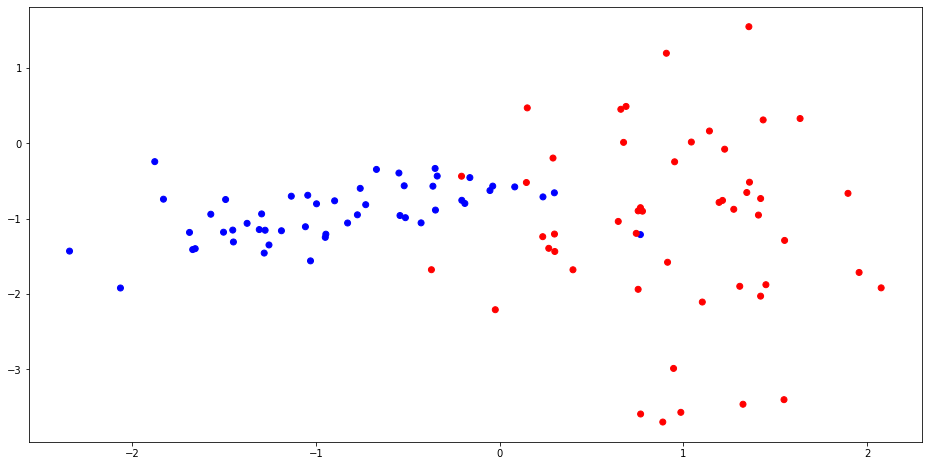

In [2]:
X, y = datasets.make_classification(n_samples=100,
                                    n_features = 2, n_informative = 2, 
                                    n_classes = 2, n_redundant=0, 
                                    n_clusters_per_class=1, random_state=23)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(16,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors);

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 

In [4]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [5]:
class DecisionTreeClassifier:
#     класс узла
    class Node:
        def __init__(self, feature_index, threshold, true_branch, false_branch):
            self.feature_index = feature_index
            self.threshold = threshold
            self.true_branch = true_branch
            self.false_branch = false_branch
        
#     класс терминального узла
    class Leaf:
        def __init__(self, X, y):
            self.X = X
            self.y = y
            classes = Counter(self.y)
            self.prediction = max(classes, key=classes.get)
            
    def __init__(self, *, max_depth=None, max_features=None, min_gain=None, min_leaf_samples=1):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_gain = min_gain
        self.min_leaf_samples = min_leaf_samples

        self.used_features = set()
        self.tree = None  
        
    def fit(self, X, y):
        self.tree = self.build_tree(np.array(X), np.array(y))
        
    def build_tree(self, X, y, current_depth=0):
        if (self.max_depth is not None) and (current_depth == self.max_depth):
            return self.Leaf(X, y)
        quality, threshold, feature_index = self.find_best_split(X, y)
        
        if (quality == 0) or ((self.min_gain is not None) and (quality < self.min_gain)):
            return self.Leaf(X, y)
        true_X, false_X, true_y, false_y = self.split(X, y, feature_index, threshold)
        if feature_index not in self.used_features:
            self.used_features.add(feature_index)
        
        true_branch = self.build_tree(true_X, true_y, current_depth + 1)
        false_branch = self.build_tree(false_X, false_y, current_depth + 1)
        
        return self.Node(feature_index, threshold, true_branch, false_branch)
    
    def find_best_split(self, X, y):
        current_gini = self.gini(y)
        
        best_quality = 0
        best_t = None
        best_feature_index = None
        
        n_features = X.shape[1]
        for feature_index in range(n_features):
            if ((self.max_features is not None) 
                and (feature_index not in self.used_features)
                and (len(used_features) == self.max_features)):
                continue
        
            threshold_values = np.unique(X[:, feature_index])
            
            for t in threshold_values:
                true_X, false_X, true_y, false_y = self.split(X, y, feature_index, t)
                if min(len(true_X), len(false_X)) < self.min_leaf_samples:
                    continue
                current_quality = self.quality(true_y, false_y, current_gini)
                
                if current_quality > best_quality:
                    best_quality, best_t, best_feature_index = current_quality, t, feature_index
        return best_quality, best_t, best_feature_index
    
    def split(self, X, y, feature_index, threshold):
        true_indexes = np.where(X[:, feature_index] <= threshold)
        false_indexes = np.where(X[:, feature_index] > threshold)
        return X[true_indexes], X[false_indexes], y[true_indexes], y[false_indexes]
    
    def quality(self, true_y, false_y, current_gini):
        true_prob = float(true_y.shape[0]) / (true_y.shape[0] + false_y.shape[0])
        return current_gini - (true_prob * self.gini(true_y)) - ((1 - true_prob) * self.gini(false_y))
    
    def gini(self, y): 
        impurity = 1
        for class_count in Counter(y).values():
            p = class_count / len(y)
            impurity = impurity - p ** 2
        return impurity
    
    def predict(self, X):
        return np.array([self.classify_object(obj, self.tree) for obj in X])
    
    def classify_object(self, obj, node):
        if isinstance(node, self.Leaf):
            return node.prediction
        
        if isinstance(obj, float):
            
            """
            костыль из-за неспособности разобраться, почему возникает ошибка 
            IndexError: invalid index to scalar variable.
            на строке 
            --> 100         if (obj[node.feature_index] <= node.threshold):   
            в classify_object(self, obj, node)
            """
            
            if obj <= node.threshold:
                return self.classify_object(obj, node.true_branch)
            else:
                return self.classify_object(obj, node.false_branch)
            
        else:
            if (obj[node.feature_index] <= node.threshold): 
                return self.classify_object(obj, node.true_branch)
            else:
                return self.classify_object(obj, node.false_branch)
            
             """конец костыля"""

In [6]:
class RandomForestClassifier:
    def __init__(self, *args, n_trees, random_state=None, oob_metric=False, **kwargs):
        self.n_trees = n_trees
        self.args = args
        self.kwargs = kwargs
        
        self.forest = []
        self.oob_metric = oob_metric
        if self.oob_metric:
            self.oob_accuracy = None
        
        if random_state:
            np.random.seed(random_state)
            
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        preds = []
        for _ in range(y.shape[0]):
            preds.append([])
        bootstraps = self.get_bootstrap_indexes(X, y, n_trees=self.n_trees)
        for obs_indexes, feat_indexes in bootstraps:
            tree = DecisionTreeClassifier(*self.args, **self.kwargs)
            tree.fit(X[obs_indexes][:, feat_indexes], y[obs_indexes])
            self.forest.append(tree)
            
        if self.oob_metric:
            oob_indexes = (i for i in range(X.shape[0]) if i not in obs_indexes)
            for i in oob_indexes:
                preds[i].append(tree.predict(X[i])[0])

            oob_preds = []
            y_copy = np.copy(y)
            for obj_preds in preds:
                avg_pred = max(set(obj_preds), key=obj_preds.count) if len(obj_preds) > 0 else None
                oob_preds.append(avg_pred)
                
            oob_indexes = [i for i , value in enumerate(oob_preds) if value is not None]
            self.oob_accuracy = accuracy_metric(y[oob_indexes], np.array(oob_preds)[oob_indexes])
            
    def get_bootstrap_indexes(self, X, y, *, n_trees, subsample=True): 
        len_subsample = int(np.sqrt(X.shape[1]))
        for i in range(n_trees):
            n_obs, n_feat = X.shape
            obs_indexes = np.random.choice(np.arange(n_obs), size=n_obs, replace=True)
            feat_indexes = np.arange(n_feat)
            if subsample:
                feat_indexes = np.random.choice(feat_indexes, size=len_subsample, replace=True)
        yield obs_indexes, feat_indexes
    
    def predict(self, X):
        X = np.array(X)
        y_pred = []
        
        for classes in zip(*[tree.predict(X) for tree in self.forest]):
            y_pred.append(max(set(classes), key=classes.count))
            
        return y_pred

In [7]:
rf_oob = RandomForestClassifier(n_trees=100, max_depth=3, random_state=123, oob_metric=True)
rf_oob.fit(X, y)
rf_oob.oob_accuracy

83.33333333333334

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 

In [9]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

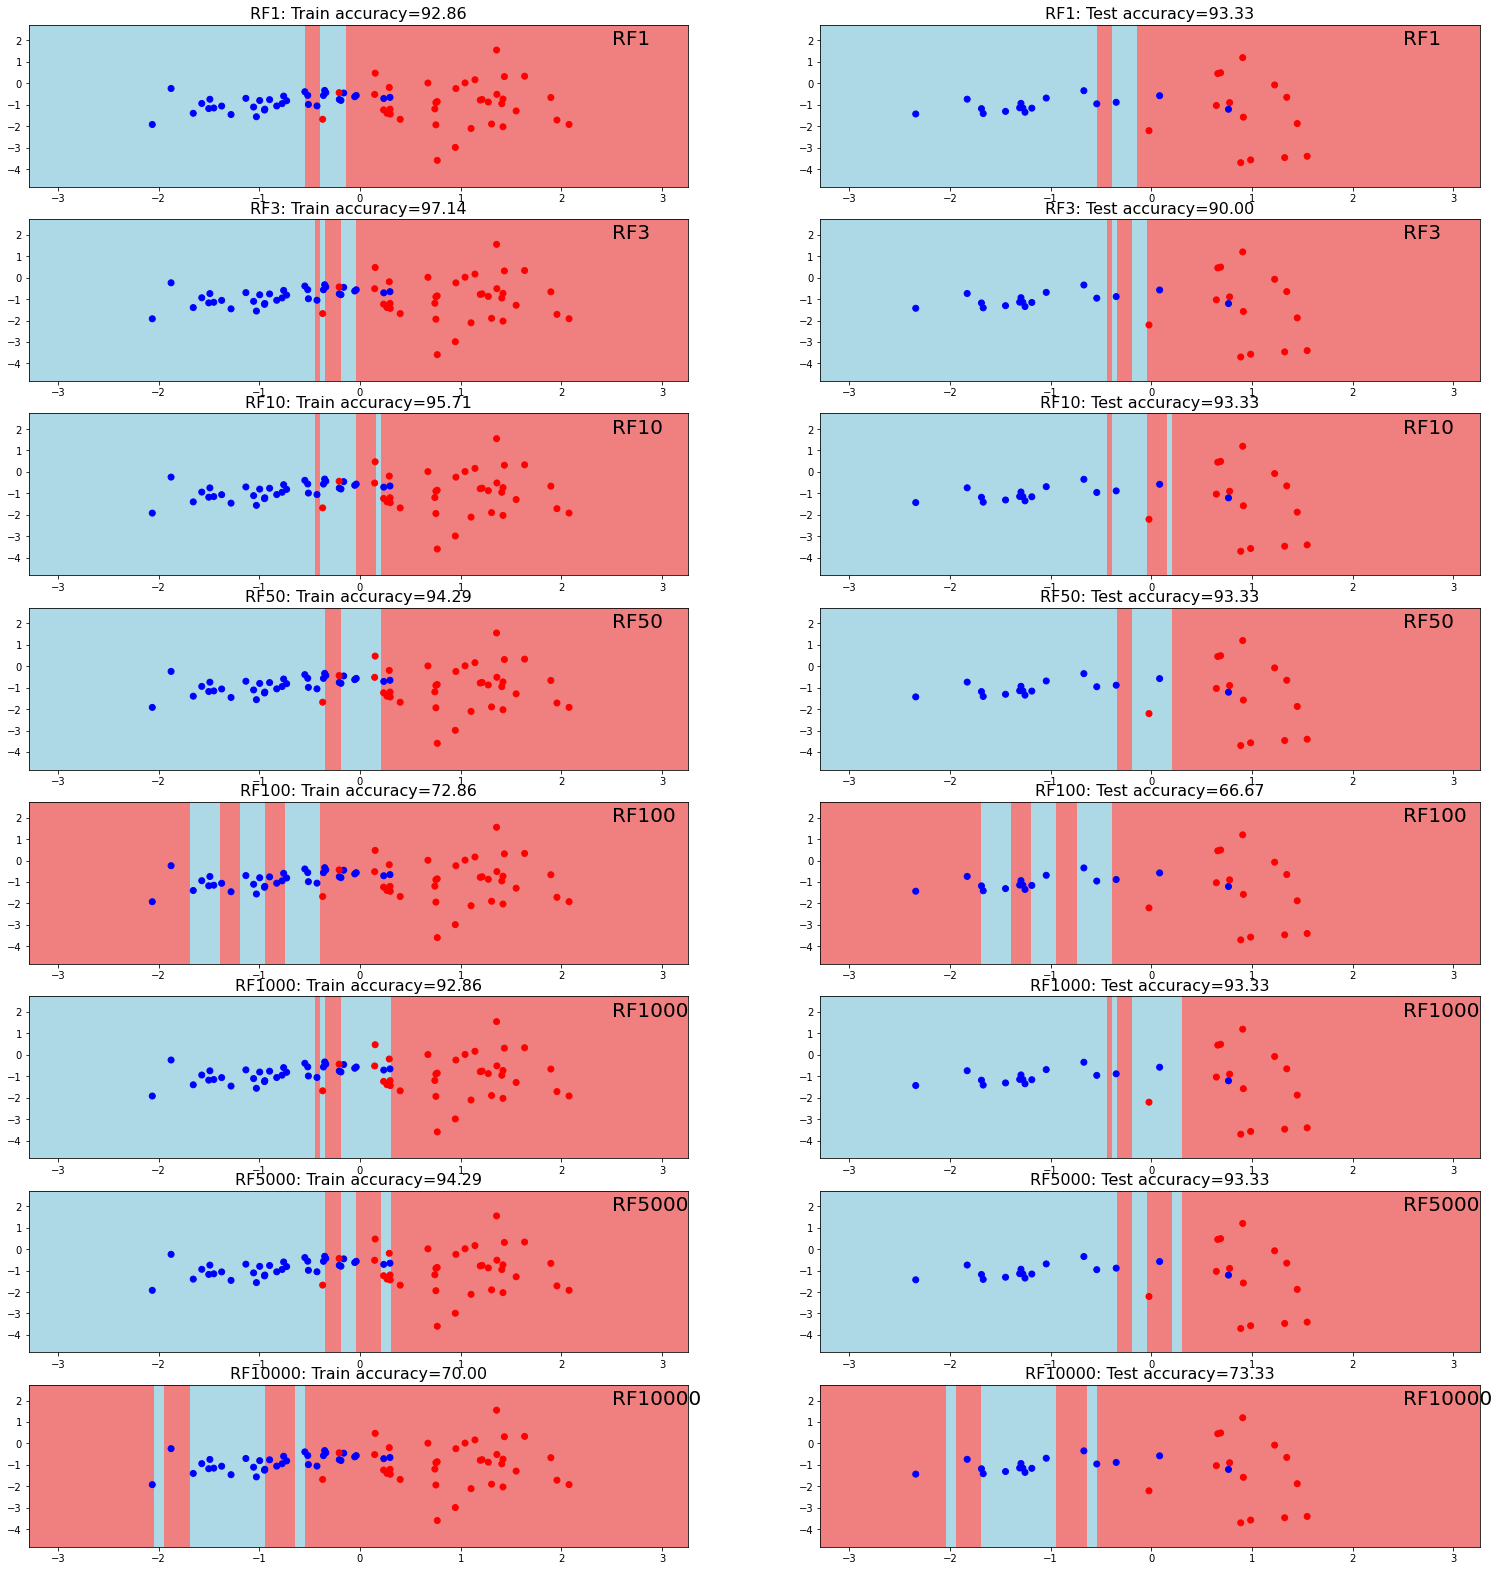

In [116]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

tree_counts = [1, 3, 10, 50, 100, 1000, 5000, 10000]
accuracy_values = {'train': [], 'test': []}
fig, axes = plt.subplots(len(tree_counts), 2, figsize = (26, 28))

for i, n_trees in enumerate(tree_counts):
    rf_model = RandomForestClassifier(n_trees=n_trees, random_state=56, max_depth=5)
    rf_model.fit(X_train, y_train)
    train_preds = rf_model.predict(X_train)
    test_preds = rf_model.predict(X_test)
    xx, yy = get_meshgrid(X_train)
    mesh_predictions = np.array(rf_model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    train_accuracy = accuracy_metric(y_train, train_preds)
    test_accuracy = accuracy_metric(y_test, test_preds)
#     график обучающей выборки
    axes[i][0].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    axes[i][0].scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
    axes[i][0].set_title(f'RF{n_trees}: Train accuracy={train_accuracy:.2f}', fontsize=16);
    axes[i][0].text(2.5, 1.8, f'RF{n_trees}', fontsize = 20)
    accuracy_values['train'].append(train_accuracy)
    # график тестовой выборки
    axes[i][1].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    axes[i][1].scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors);
    axes[i][1].set_title(f'RF{n_trees}: Test accuracy={test_accuracy:.2f}', fontsize=16);
    axes[i][1].text(2.5, 1.8, f'RF{n_trees}', fontsize = 20);
    accuracy_values['test'].append(test_accuracy)
plt.show()

<p style='background-color: #ef7; padding: 10px'>
    Самую низкую точность предсказаний получил ансамбль из ста деревьев, к этому добавим явное переобучение.
    Интересно, что точность на train и test леса из одного дерева равна точности леса из тысячи деревьев.
</p>

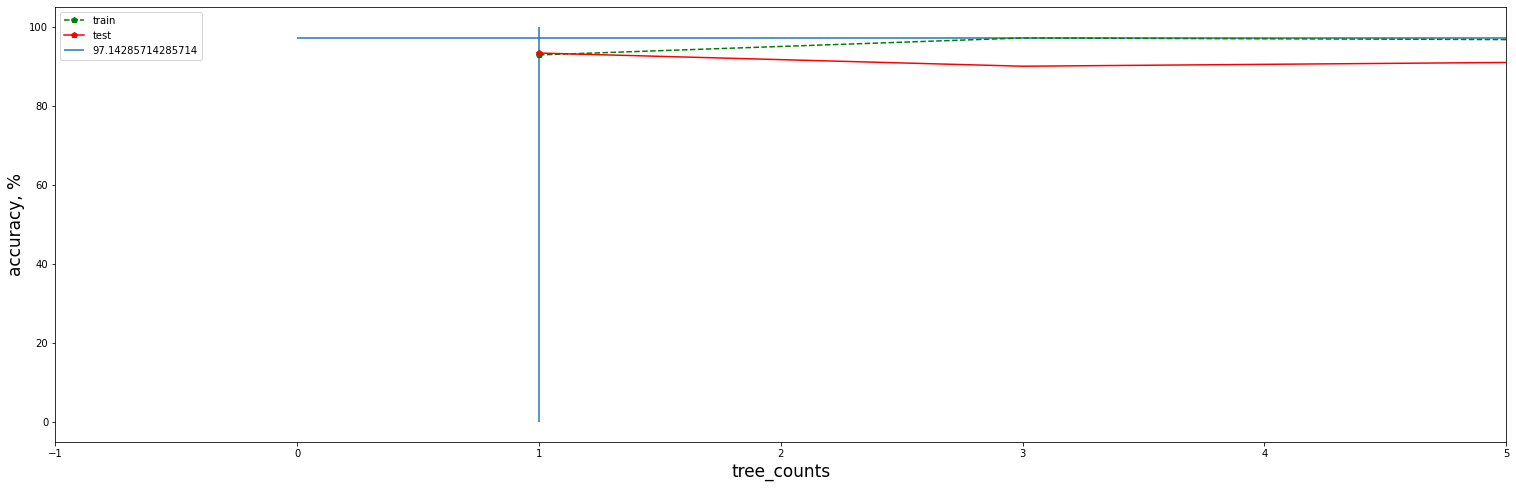

In [122]:
plt.figure(figsize=(26, 8))

markers_train = max(accuracy_values['train'])
plt.plot(tree_counts, accuracy_values['train'], '--gp', label='train', markevery=markers_train);

markers_test = max(accuracy_values['test'])
plt.plot(tree_counts, accuracy_values['test'], '-rp', label='test', markevery=markers_test);

plt.xlabel('tree_counts', fontdict={'fontsize': 17})
plt.ylabel('accuracy, %', fontdict={'fontsize': 17})

plt.vlines(x=1, ymin=0, ymax=100)
plt.hlines(y=max( max(accuracy_values['train']), max(accuracy_values['test']) ), xmin=0, xmax=max(tree_counts), label=f"{max( max(accuracy_values['train']), max(accuracy_values['test']) )}");

plt.xlim(-1, 5)
plt.legend();

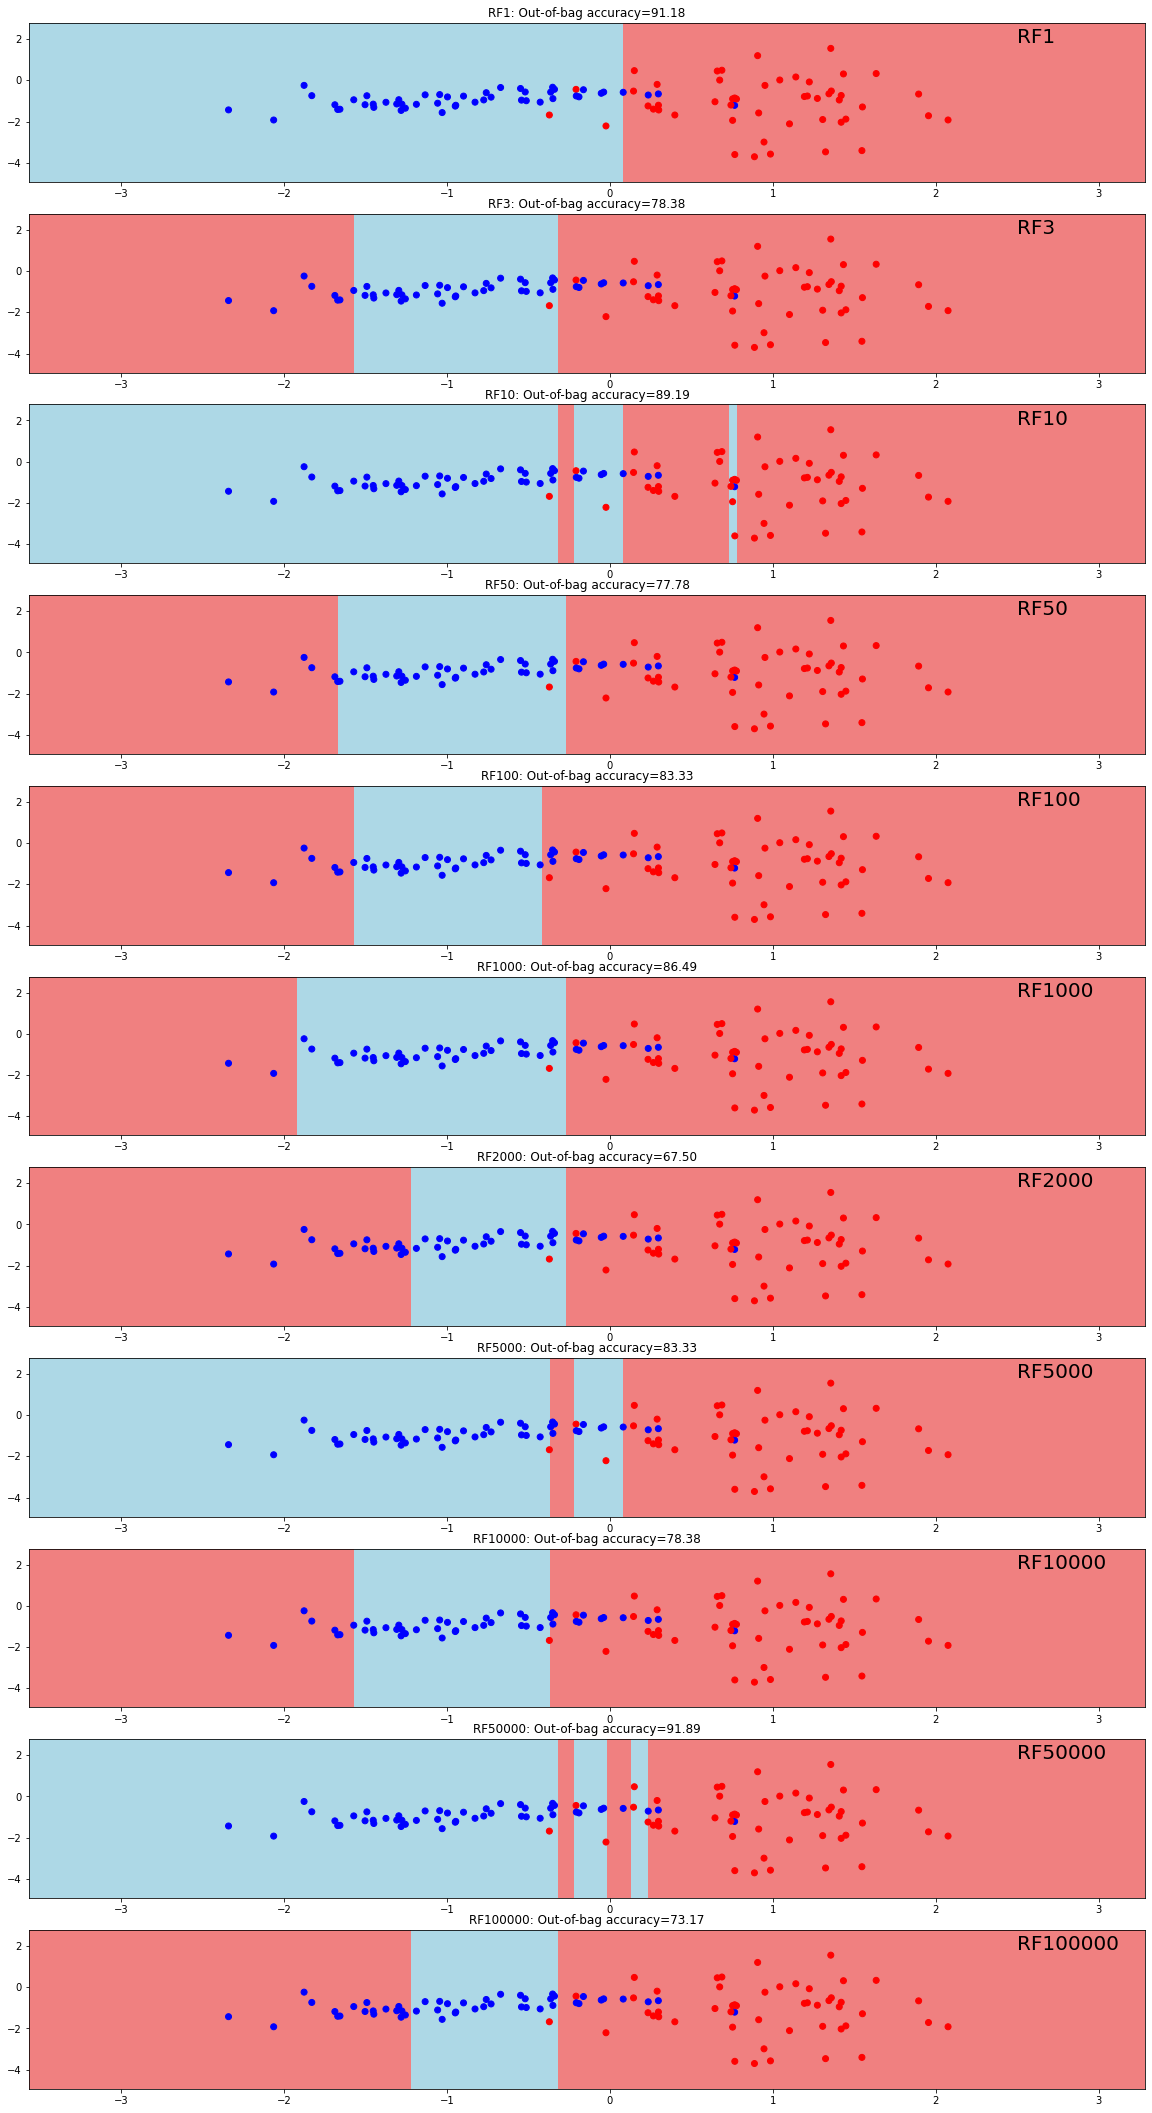

In [125]:
# с использованием out-of-bag error
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
tree_counts = [1, 3, 10, 50, 100, 1000, 2000, 5000, 10000, 50000, 100000]
accuracy_values = []

fig, axes = plt.subplots(len(tree_counts), 1, figsize = (20, 38))
for i, n_trees in enumerate(tree_counts):
    rf_oob = RandomForestClassifier(n_trees=n_trees, max_depth=3, random_state=123, oob_metric=True)
    rf_oob.fit(X, y)
    preds = rf_oob.predict(X)
    xx, yy = get_meshgrid(X)
    mesh_predictions = np.array(rf_oob.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    oob_accuracy = rf_oob.oob_accuracy
#     график обучающей выборки
    axes[i].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    axes[i].scatter(X[:, 0], X[:, 1], c = y, cmap = colors)
    axes[i].set_title(f'RF{n_trees}: Out-of-bag accuracy={oob_accuracy:.2f}');
    axes[i].text(2.5, 1.8, f'RF{n_trees}', fontsize = 20)
    accuracy_values.append(oob_accuracy)

plt.show()

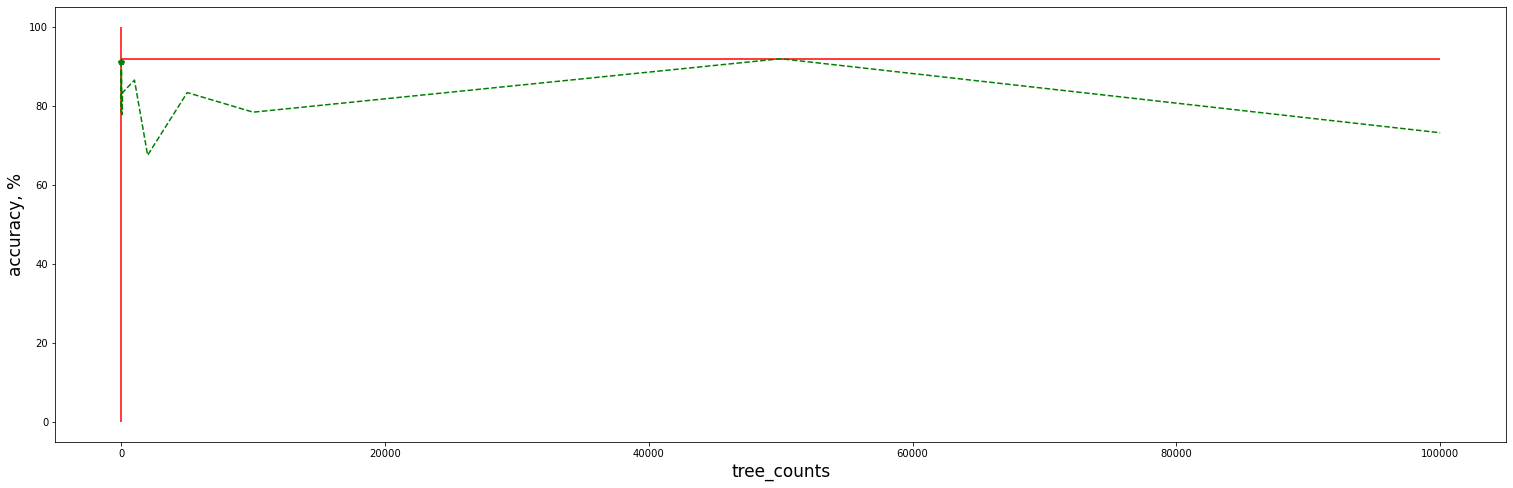

In [126]:
plt.figure(figsize=(26, 8))

markers = max(accuracy_values)
plt.plot(tree_counts, accuracy_values, '--gp', markevery=markers);

plt.xlabel('tree_counts', fontdict={'fontsize': 17})
plt.ylabel('accuracy, %', fontdict={'fontsize': 17})

plt.vlines(x=1, ymin=0, ymax=100,  color='r')
plt.hlines(y=max(accuracy_values), xmin=0, xmax=max(tree_counts), color='r');
# plt.xlim(-100, 10)

<p style='background-color: #ef7; padding: 10px'>
    Лучший результат в случае оценки методом out-of-bag error получился на модели, использующей всего одно дерево, пока в конец списка trees_counts не было добавлено большое число 5e4. Скорее всего строить столько деревьев решений просто неэффективно. 
    
</p>

#### Энтропия Шеннона для задач регрессии
**эта задача несоизмеримо проста по сравнению с имплементацией out-of-bag-error*

In [ ]:
def gini(self, y): 
        for class_count in Counter(y).values():
            p = class_count / len(y)
        return -(np.sum(p * np.log2(p)))